# Memory Game - automatic detection

### We created a memory game, that the user can choose the photos he would like to play with, and the "game" matches the pairs automatic.
### In this notebook you can find the algoritm, based on SIFT method. The full game (the algo + GUI) was submitted as a separate file. 


Keren and Ann

#### Import Libraries

In [55]:
import cv2 
import pickle
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import glob
from PIL import Image, ImageFont, ImageDraw 


### Functions

In [171]:



#The keypoints are generated on the grayscale images
def imagesBW(imageList):
    images_BW = []
    for imageName in imageList:
        imagePath = "data/images/" + str(imageName)
        #print(imagePath)
        images_BW.append(imageResize(cv2.imread(imagePath,0)))
    return images_BW

#all images are being resized so we will focus on relevant keypoints
def imageResize(image):
    maxD = 1024
    height,width = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image

#all images are being resized so we will focus on relevant keypoints
def imageResizeBW(image):
    maxD = 1024
    height,width,channel = image.shape
    aspectRatio = width/height
    if aspectRatio < 1:
        newSize = (int(maxD*aspectRatio),maxD)
    else:
        newSize = (maxD,int(maxD/aspectRatio))
    image = cv2.resize(image,newSize)
    return image


def computeSIFT(image):
    sift = cv2.xfeatures2d.SIFT_create()
    return sift.detectAndCompute(image, None)

    
#compute keypoints and descriptors based on sift
#we save them, so we will be able to use the results in a loop without computing every time
def keypoints_descriptors(imageList):
    images_BW=imagesBW(imageList)
    keypoints = []
    descriptors = []
    i = 0
    for image in images_BW:
        keypointTemp, descriptorTemp = computeSIFT(image)
        keypoints.append(keypointTemp)
        descriptors.append(descriptorTemp)
        i += 1

    i = 0
    for keypoint in keypoints:
        deserializedKeypoints = []
        filepath = "data/keypoints/" + str(imageList[i].split('.')[0]) + ".txt"
        for point in keypoint:
            temp = (point.pt, point.size, point.angle, point.response, point.octave, point.class_id)
            deserializedKeypoints.append(temp)
        with open(filepath, 'wb') as fp:
            pickle.dump(deserializedKeypoints, fp)    
        i += 1


    i = 0
    for descriptor in descriptors:
        filepath = "data/descriptors/" + str(imageList[i].split('.')[0]) + ".txt"
        with open(filepath, 'wb') as fp:
            pickle.dump(descriptor, fp)
        i += 1

def fetchKeypointFromFile(i):
    filepath = "data/keypoints/" + str(imageList[i].split('.')[0]) + ".txt"
    keypoint = []
    file = open(filepath,'rb')
    deserializedKeypoints = pickle.load(file)
    file.close()
    for point in deserializedKeypoints:
        temp = cv2.KeyPoint(x=point[0][0],y=point[0][1],_size=point[1], _angle=point[2], _response=point[3], _octave=point[4], _class_id=point[5])
        keypoint.append(temp)
    return keypoint

def fetchDescriptorFromFile(i):
    filepath = "data/descriptors/" + str(imageList[i].split('.')[0]) + ".txt"
    file = open(filepath,'rb')
    descriptor = pickle.load(file)
    file.close()
    return descriptor

#calculating the basic matching score for 2 specific images
def calculateScore(matches,keypoint1,keypoint2):
    return 100 * (matches/min(keypoint1,keypoint2))

# Calculating the Results for any pair
def calculateResultsFor(i,j):
    keypoint1 = fetchKeypointFromFile(i)
    descriptor1 = fetchDescriptorFromFile(i)
    keypoint2 = fetchKeypointFromFile(j)
    descriptor2 = fetchDescriptorFromFile(j)
    matches = calculateMatches(descriptor1, descriptor2)
    score = calculateScore(len(matches),len(keypoint1),len(keypoint2))
    plot = getPlotFor(i,j,keypoint1,keypoint2,matches)
    return(score, plot)

def showplot(plot):
    plt.imshow(plot),plt.show()


def getPlotFor(i,j,keypoint1,keypoint2,matches):
    image1 = imageResizeBW(cv2.imread("data/images/" + imageList[i]))
    image2 = imageResizeBW(cv2.imread("data/images/" + imageList[j]))
    return getPlot(image1,image2,keypoint1,keypoint2,matches)

#resize the images for the gui
def changeImageSize(i, basewidth=90):
    img = Image.open("data/images/" + imageList[i])
    wpercent = (basewidth/float(img.size[0]))
    hsize = 90
    img = img.resize((basewidth,hsize), Image.ANTIALIAS)
    return img

#resize and save the pairs with the relevant name
def pairOutput(i,j,pair_num):
    image1 = changeImageSize(i)
    image2 = changeImageSize(j)
    new_i = image1    
    new_j = image2

    
    
    image1_name="data/results/pair" + str(pair_num) +"_1.jpeg"
    image2_name="data/results/pair" + str(pair_num) +"_2.jpeg"
    
    image1.save(image1_name)
    image2.save(image2_name)
    
    image1_open = Image.open(image1_name)
    image2_open = Image.open(image2_name)
    number_text = str(pair_num)
    black = 'rgb(0, 0, 0)' # black color
    image_editable = ImageDraw.Draw(image1_open)
    image_editable.text((14, 14), number_text, fill=black)
    image_editable.text((14, 16), number_text, fill=black)
    image_editable.text((16, 14), number_text, fill=black)
    image_editable.text((16, 16), number_text, fill=black)
    image_editable.text((15, 15), number_text)
    image1_open.save(image1_name)

    image_editable = ImageDraw.Draw(image2_open)
    image_editable.text((14, 14), number_text, fill=black)
    image_editable.text((14, 16), number_text, fill=black)
    image_editable.text((16, 14), number_text, fill=black)
    image_editable.text((16, 16), number_text, fill=black)
    image_editable.text((15, 15), number_text)
    image2_open.save(image2_name)    
    
 #   showplot(image1_open)
  #  showplot(image2_open)    
    
    return (image1,image2)


#  matching descriptors by knn 
def calculateMatches(des1,des2):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2,k=2)
    topResults1 = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults1.append([m])
            
    matches = bf.knnMatch(des2,des1,k=2)
    topResults2 = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            topResults2.append([m])
    
    topResults = []
    for match1 in topResults1:
        match1QueryIndex = match1[0].queryIdx
        match1TrainIndex = match1[0].trainIdx

        for match2 in topResults2:
            match2QueryIndex = match2[0].queryIdx
            match2TrainIndex = match2[0].trainIdx

            if (match1QueryIndex == match2TrainIndex) and (match1TrainIndex == match2QueryIndex):
                topResults.append(match1)
    return topResults


def getPlot(image1,image2,keypoint1,keypoint2,matches):
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
    matchPlot = cv2.drawMatchesKnn(image1,keypoint1,image2,keypoint2,matches,None,[255,255,255],flags=2)
    return matchPlot

#building the score matrix
def scores_matrix(imageList):
    length = len(imageList)
    scores = np.zeros([length,length])
    for i in range(length):
        for j in range(i):
           # print("i: ",i,"j: ", j)
            score,plot=calculateResultsFor(i,j)
            scores[i,j] = score
    scores=scores.tolist()
    return scores

#finding all posible pairs
def all_pairs(lst):
    if len(lst) < 2:
        yield []
        return
    if len(lst) % 2 == 1:
        # Handle odd length list
        for i in range(len(lst)):
            for result in all_pairs(lst[:i] + lst[i+1:]):
                yield result
    else:
        a = lst[0]
        for i in range(1,len(lst)):
            pair = (a,lst[i])
            for rest in all_pairs(lst[1:i]+lst[i+1:]):
                yield [pair] + rest
                
                
#compare the score of all pairs' combinations
def find_best_pairs(imageList):
    images_len=len(imageList)
    images_len_list = list(range(images_len))
    all_comb_scores=[]
    combinations = all_pairs(images_len_list)
    for combination in combinations:
        combination_score=0
       # print(combination)
        for pair in combination:
            pair_score = (scores[pair[0]][pair[1]]+scores[pair[1]][pair[0]])
        #    print(pair)   
            combination_score+=pair_score
        all_comb_scores.append(combination_score)
       # print(all_comb_scores)

    best_pairs_index=all_comb_scores.index(max(all_comb_scores))

    combinations = all_pairs(images_len_list)

    for combination_num, combination in enumerate(combinations):

        if combination_num==best_pairs_index:
          #  print(combination_num)
           # print(combination)
            for pair_num,pair in enumerate(combination):
                score, plot=calculateResultsFor(pair[0],pair[1])     
                print("score: ", score)
                showplot(plot)
                pairOutput(pair[0],pair[1],pair_num)
                


### The Matched pairs 

score:  5.5


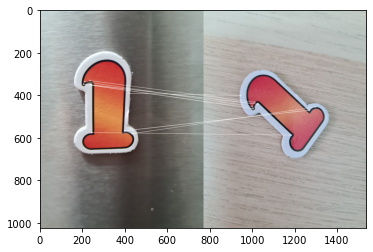

score:  1.7167381974248928


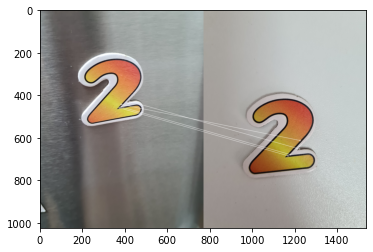

score:  3.65296803652968


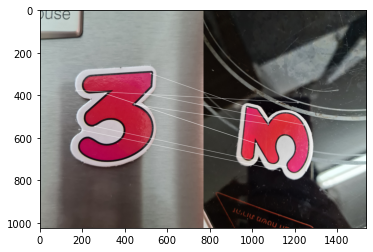

score:  9.803921568627452


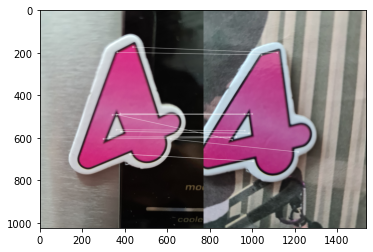

score:  6.315789473684211


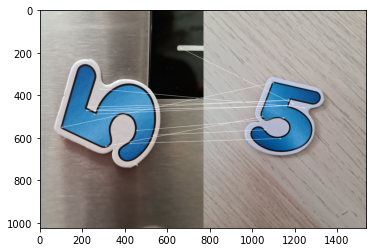

score:  4.545454545454546


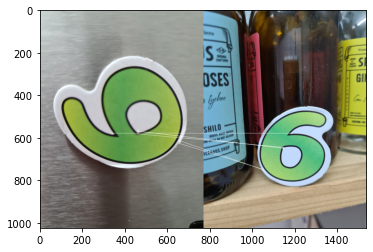

In [172]:
###here we define the images we are going to use 

imageList = [
"20210407_181124.jpg",
"20210407_181132.jpg",
"20210407_181140.jpg",
"20210407_181144.jpg",
"20210407_181155.jpg",
"20210407_181201.jpg",
"20210407_181208.jpg",
"20210407_181214.jpg",
"20210407_181220.jpg",
"20210407_181237.jpg",
"20210407_181248.jpg",
"20210407_181300.jpg",
]

scores = scores_matrix(imageList)
best_combination = find_best_pairs(imageList)





### The scores Matrix:
#### Each row and column represents a specific image, the (i,j) value in the matrix is the matching score of image i and image j
#### based on this matrix the algorithm chooses the combination of pairs that has the maximum sum of scores

In [164]:

print(np.matrix(scores))

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [5.5        0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.         0.8583691  0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.5        0.34364261 1.7167382  0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.5        0.         0.91324201 0.         0.         0.
  0.         0.         0.         0.         0.         0.        ]
 [0.5        0.         0.8583691  0.96774194 3.65296804 0.
  0.         0.         0.         0.         0.         0.        ]
 [0.65359477 0.         1.30718954 0.         1.96078431 1.96078431
  0.         0.         0.         0.         0.         0.        ]
 [0.5        0.         1.7167382  1.18577075 0.456621   0.39525692
  9.80392157 0.      

#### The images output, as displayed in the memory game

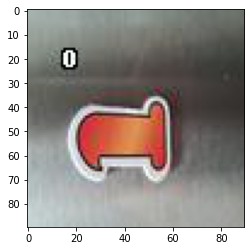

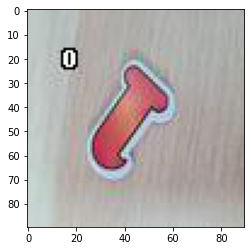

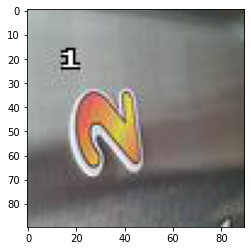

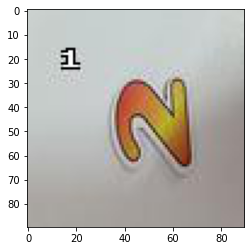

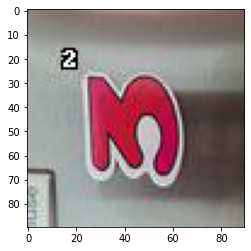

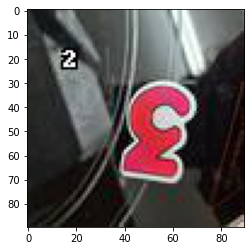

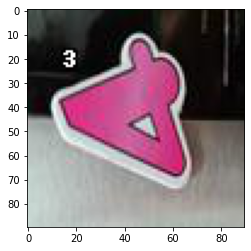

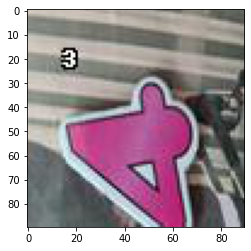

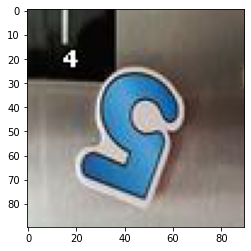

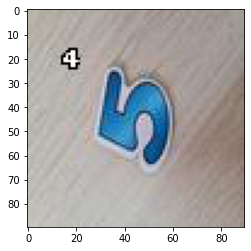

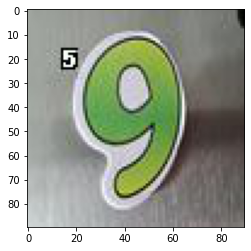

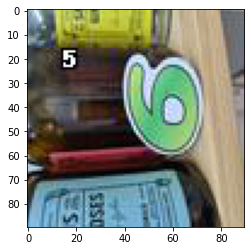

In [176]:
for i in range(6):
    image_name ="data/results/pair" + str(i) +"_1.jpeg"
    image = Image.open(image_name)
    showplot(image)
    image_name ="data/results/pair" + str(i) +"_2.jpeg"
    image = Image.open(image_name)
    showplot(image)